In [18]:
import numpy as np
import pandas as pd
import torch.cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import tqdm
import torch.backends.cudnn as cudnn

from models.htr_net import HTRNet
from utils.save_load import my_torch_load

feature map extraction code taken from: https://androidkt.com/how-to-visualize-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [19]:
classes = '_@,-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ '
cnn_cfg = [(2, 32), 'M', (4, 64), 'M', (6, 128), 'M', (2, 256)]
rnn_cfg = (256, 1)  # (hidden , num_layers)

In [20]:
model = 'real_10epochs_alphanumeric.pt'
net = HTRNet(cnn_cfg, rnn_cfg, len(classes))
my_torch_load(net, model);

Print weights:

In [22]:
# weights = []
# for param in net.parameters():
#     print(param.data)
#     weights.append(param.data)

In [23]:
import cv2
import random
import matplotlib.pyplot as plt
from skimage import io as img_io
from utils.auxilary_functions import image_resize, centered
import os
from shutil import copyfile

In [24]:
def get_conv_layers(net):
    no_of_layers=0
    conv_layers=[]

    model_children=list(net.children())
#     print(len(model_children))

    count = 0
    for child in model_children:
#         print(count)
        if type(child) == nn.Conv2d:
            no_of_layers+=1
            conv_layers.append(child)

        if type(child) != torch.nn.modules.rnn.LSTM:
            for layer in child:
                if type(layer)==nn.Conv2d:
                    no_of_layers+=1
                    conv_layers.append(layer)
        count = count + 1
        
    return conv_layers

In [25]:
def get_feature_maps(net, img, net_name):

    outputs = []
    conv_layers = get_conv_layers(net)
    results = [conv_layers[0](Variable(img).unsqueeze(0))]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
    outputs = results
    
    fn = "feature_maps_" + net_name + ".txt"
    if os.path.exists(fn):
        f = open(fn, "r+")
        f.truncate(0)
        f.close()
        
    all_stats = []
    
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(60, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        
        print("Layer ",num_layer+1)
        stats = []
        
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            plt.subplot(8, 2, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
            fil = np.array(filter)
            stats.append([np.mean(fil), np.var(fil)])
            
        stats = sorted(stats)
#         for row in stats:
#             print(np.round(row,6))
            
        f = open(fn, "a")
        f.write("Layer " + str(num_layer) + "\n")
        for row in stats:
            st = str(round(row[0],6)) + ", " + str(round(row[1],6)) + "\n"
            f.write(st)
        f.write("\n")
        f.close()
    
        plt.savefig("feature_maps/layer" + str(num_layer) + "_" + net_name + '.png')
#         plt.show()
        plt.close()
#         break
        all_stats.append(stats)
    return np.array(all_stats)

Read in image:

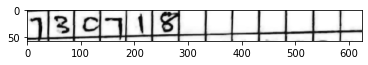

In [26]:
im_file = "real_only/1348612.png"
img = img_io.imread(im_file)
# img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

Prep image:

In [27]:
nheight = 128
nwidth = int(np.random.uniform(.8, 1.2) * img.shape[1] * nheight / img.shape[0])

img = image_resize(img, height=nheight-16, width=nwidth)
img = centered(img, (nheight, int(1.2 * nwidth) + 32))
img = torch.Tensor(img).float().unsqueeze(0)

Get stats:

In [28]:
statsr = get_feature_maps(net, img, "name")

Layer  1
Layer  2
Layer  3
Layer  4
Layer  5
Layer  6
Layer  7
Layer  8
Layer  9
Layer  10
Layer  11
Layer  12
Layer  13
Layer  14


Plot means of feature maps:

In [30]:
for i in range(14):
    plt.figure(figsize=(14, 10))
    plt.plot(statsr[i][:,0], label="network1", linewidth=3)
#     plt.plot(stats_n1[i][:,0], label="network2", linewidth=3)
    plt.legend()
    plt.xlabel("feature_map")
    plt.ylabel("mean pixel value")
    plt.savefig("plots/means_layer" + str(i) + ".jpg", dpi=100) 
    plt.close()

Plot variances of feature maps:

In [31]:
for i in range(14):
    plt.figure(figsize=(14, 10))
    plt.plot(statsr[i][:,1], label="network1", linewidth=3)
#     plt.plot(stats_n1[i][:,1], label="network2", linewidth=3)
    plt.legend()
    plt.xlabel("feature_map")
    plt.ylabel("pixel variance")
    plt.savefig("plots/var_layer" + str(i) + ".jpg", dpi=100) 
    plt.close()

Plot average variance for each feature map:

In [32]:
plt.figure(figsize=(14, 10))
plt.yscale("log")
plt.plot(np.mean(statsr[:,:,1], axis=1), label="network1", linewidth=3)
# plt.plot(np.mean(stats_n1[:,:,1], axis=1), label="network2", linewidth=3)
plt.legend()
plt.xlabel("network layer")
plt.ylabel("mean pixel variance")
plt.savefig("plots/average_var.jpg", dpi=100) 
plt.close()